In [3]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Beyond Single Runs: Tendency Analysis of Non-Deterministic Eval Tasks



<table align="left">

</table>

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fgenai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Alejandro Ballesta](https://www.linkedin.com/in/alejandroballestae/) |

**_NOTE_**: This notebook has been tested in the following environment:

* Python version >= 3.10

## Overview

This notebook explores the application of statistical methods to gain insights into the behavior of the **Vertex AI Python SDK for Gen AI Evaluation Service** for generated answers during **Question Answering** (QA) tasks. Due to the inherent variability, non-deterministic or probabilistic outcomes in these tasks, relying on a single execution may not provide a comprehensive understanding of the real performance.


We'll delve into techniques to aggregate and analyze results from multiple runs, enabling us to:
* **Identifying the problem:** running multiple tests over the same data to understand the non-deterministic outputs
* **Setting up a more reliable approach:** using the same pair of questions and contexts, we will use the generated answers of two different models (ex. Gemini 1.5 vs Gemini Flash) as an input to our method and demonstrate an extensive methodology to derive better conclusions
* **Running the experiment:** for each model, we will run the QA Gen AI Evaluation Service method 40 times to extract multiple performance metrics
* **Quantifying Performance:** we will calculate key statistical measures like mean, median, and standard deviation to gauge central tendency and variability across executions.
* **Identifying Performance:** In this section, using the statistical measures calculated, we will visualize the distributions of each metric overlapping the results of both models in the same chart
* **Assessing Confidence:** applying confidence intervals or hypothesis testing we will draw statistically sound conclusions about the performance of eval tasks.
By leveraging these statistical tools, we aim to move beyond single-run observations and gain a more robust understanding of the true behavior and capabilities of these non-deterministic tasks.
* **Comparing Results:** we will plot a radar chart and determine which model is better for our own goals

**Note:** The purpose of this analysis is not to have a completely statistical (since we are making a lot of assumptions) proof, but to gain a more holistic view of the architecture's performance


## Getting Started

### Install Vertex AI SDK for Gen AI Evaluation Service

In [5]:
%pip install --upgrade --user --quiet google-cloud-aiplatform[evaluation]
%pip install --quiet --upgrade nest_asyncio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Restart runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [6]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

In [7]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

In [8]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "[your-location]"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [9]:
# General
from IPython.display import display, Markdown, HTML
import logging
import nest_asyncio
import warnings

# Main
from vertexai.preview.evaluation import EvalTask
import pandas as pd

### Library settings

In [10]:
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
nest_asyncio.apply()
warnings.filterwarnings("ignore")

# **Identifying the problem**
In this section we are going to run 2 independent evaluation tasks and gather evidence of different results under the same following conditions:
* **Questions:** set of 5 random questions (same questions for each test)
* **Retrieved context:** for the purpose of this notebook we assume that the context is retrieved with any particular method
* **Generated answers:** we are going to use the answers already presented on the Gen AI Evaluation Service Getting Started notebook ([evaluate_rag_rapid_eval](https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/evaluate_rag_rapid_evaluation_sdk.ipynb))


## Prepare Dataset

To evaluate the RAG generated answers, the evaluation dataset is required to contain the following fields:

* Question
* Context
* RAG Generated Answer

In [11]:
questions = [
    "Which part of the brain does short-term memory seem to rely on?",
    "What provided the Roman senate with exuberance?",
    "What area did the Hasan-jalalians command?",
    "How many pencils could be made from the carbon in an average adult human body?"
]

retrieved_contexts = [
    "Short-term memory is supported by transient patterns of neuronal communication, dependent on regions of the frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe. Long-term memory, on the other hand, is maintained by more stable and permanent changes in neural connections widely spread throughout the brain. The hippocampus is essential (for learning new information) to the consolidation of information from short-term to long-term memory, although it does not seem to store information itself. Without the hippocampus, new memories are unable to be stored into long-term memory, as learned from patient Henry Molaison after removal of both his hippocampi, and there will be a very short attention span. Furthermore, it may be involved in changing neural connections for a period of three months or more after the initial learning.",
    "In 62 BC, Pompey returned victorious from Asia. The Senate, elated by its successes against Catiline, refused to ratify the arrangements that Pompey had made. Pompey, in effect, became powerless. Thus, when Julius Caesar returned from a governorship in Spain in 61 BC, he found it easy to make an arrangement with Pompey. Caesar and Pompey, along with Crassus, established a private agreement, now known as the First Triumvirate. Under the agreement, Pompey's arrangements would be ratified. Caesar would be elected consul in 59 BC, and would then serve as governor of Gaul for five years. Crassus was promised a future consulship.",
    "The Seljuk Empire soon started to collapse. In the early 12th century, Armenian princes of the Zakarid noble family drove out the Seljuk Turks and established a semi-independent Armenian principality in Northern and Eastern Armenia, known as Zakarid Armenia, which lasted under the patronage of the Georgian Kingdom. The noble family of Orbelians shared control with the Zakarids in various parts of the country, especially in Syunik and Vayots Dzor, while the Armenian family of Hasan-Jalalians controlled provinces of Artsakh and Utik as the Kingdom of Artsakh.",
    "The average adult human body contains enough carbon to make about 900 pencils"
]

generated_answers = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 901"
]


eval_dataset = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers,
    }
)

## Select Metric and Define EvalTask


Choose from the following metrics for an evaluation task. For more information about the supported evaluation metrics and how to use each metric, please see [Evaluation methods and metrics](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval).

*   `question_answering_quality` (overall quality)
*   `question_answering_relevance`
*   `question_answering_helpfulness`
*   `groundedness`
*   `fulfillment`

You can run evaluation for just one metric, or a combination of metrics. For example, we create an `EvalTask` named `answer_eval_task` with all the QA-related metrics to compute all the metrics in one eval run as follows:

In [12]:
answer_eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=[
        "question_answering_quality",
        "groundedness",
        "coherence",
        "fluency",
        "verbosity"
    ],
    experiment="rag-eval-01",
)

## Run Evaluation

In [18]:
first_result = answer_eval_task.evaluate()
second_result = answer_eval_task.evaluate()

Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-eval-01-19593aa8-fd81-48e9-88a0-428873c3028b to Experiment: rag-eval-01


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

All 20 metric requests are successfully computed.
Evaluation Took:25.440347708004992 seconds


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-eval-01-9f213407-49df-4d27-b366-2fc9836c1c32 to Experiment: rag-eval-01


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.48940570800187 seconds


In [19]:
first_result.summary_metrics

{'row_count': 4,
 'question_answering_quality/mean': np.float64(3.75),
 'question_answering_quality/std': np.float64(0.9574271077563381),
 'groundedness/mean': np.float64(0.25),
 'groundedness/std': np.float64(0.5),
 'coherence/mean': np.float64(2.5),
 'coherence/std': np.float64(1.9148542155126762),
 'fluency/mean': np.float64(3.0575),
 'fluency/std': np.float64(1.7435285104255298),
 'verbosity/mean': np.float64(-1.25),
 'verbosity/std': np.float64(0.5)}

#Let's compare the results of running the same experiment twice

In [20]:
first_df = pd.DataFrame(first_result.metrics_table)
second_df = pd.DataFrame(second_result.metrics_table)

first_df = first_df.add_prefix('first_')
second_df = second_df.add_prefix('second_')

result = pd.concat([first_df, second_df], axis=1)
result[["first_question_answering_quality/score","second_question_answering_quality/score"]]


,first_question_answering_quality/score,second_question_answering_quality/score
0,3.0,4.0
1,4.0,3.0
2,5.0,5.0
3,3.0,2.0


You are probably seeing different results for at least one row; if not, try again
:)

# **Setting up a more reliable approach**

if you are comparing two differnt architectures (Ex, Gemini 1.5 generations vs Gemini Flash generations), it's recommended to use sample distributions to understand the perfomance of each approach.

Let's see one example


## Modal A vs Model B set up

In [21]:
generated_answers_modal_a = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 900 pencils could be made from an adult human body"
]

generated_answers_model_b = [
    "frontal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded Vayots Dzor",
    "I would guess 901"
]

eval_dataset_model_a = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_modal_a,
    }
)
eval_dataset_model_b = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_model_b,
    }
)

#**Running the experiment**

Once the answers have been generated, let's run 40 identical experiments for each approach

In [22]:
#Let's first define the metrics we are going to use

metrics = ["question_answering_quality",
        "groundedness",
        "coherence",
        "fluency",
        "verbosity"]
n=40

In [23]:
#Model A - 40 iteration evaluation

model_a_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_a,
      metrics=metrics,
      experiment=f"rag-model-a-1-5-eval-{i}",
  )
  model_a_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-0-76d72f10-81b3-4235-aa3e-1735e0a03ff9 to Experiment: rag-model-a-1-5-eval-0


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.770478459002334 seconds


running experiment 1-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-1-9fd9184c-de04-409b-9362-46138b0b9ea9 to Experiment: rag-model-a-1-5-eval-1


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.905185749994416 seconds


running experiment 2-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-2-6e141051-ce13-4edb-bad0-28253e5f9a19 to Experiment: rag-model-a-1-5-eval-2


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.00476845799858 seconds


running experiment 3-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-3-4ea4504c-b1ac-466f-b1d2-c038dda8d8e4 to Experiment: rag-model-a-1-5-eval-3


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.877192166000896 seconds


running experiment 4-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-4-a3f2bb6f-60de-473f-a9d4-56d42d660958 to Experiment: rag-model-a-1-5-eval-4


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

All 20 metric requests are successfully computed.
Evaluation Took:25.209727707995626 seconds


running experiment 5-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-5-1e49fba7-38ec-4bc9-a219-a34f0ad32360 to Experiment: rag-model-a-1-5-eval-5


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.88313470799767 seconds


running experiment 6-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-6-560a43a0-feb7-431c-be3d-7920851cd7bc to Experiment: rag-model-a-1-5-eval-6


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

All 20 metric requests are successfully computed.
Evaluation Took:25.1007063750003 seconds


running experiment 7-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-7-1dfb02c3-8b24-45e3-b3c5-4e94364c6b49 to Experiment: rag-model-a-1-5-eval-7


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.736961708003946 seconds


running experiment 8-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-8-d719e693-985c-4952-a717-75f9ad79f8ae to Experiment: rag-model-a-1-5-eval-8


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

All 20 metric requests are successfully computed.
Evaluation Took:22.602515625003434 seconds


running experiment 9-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-9-9600b959-0a9d-4fec-a07b-1156a47db8da to Experiment: rag-model-a-1-5-eval-9


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.874778500001412 seconds


running experiment 10-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-10-f06a7826-daff-4b19-9656-cd61ccae5f5a to Experiment: rag-model-a-1-5-eval-10


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.066375000002154 seconds


running experiment 11-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-11-9341482c-116f-4cce-9958-6461be3cf3f2 to Experiment: rag-model-a-1-5-eval-11


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.38555404199724 seconds


running experiment 12-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-12-49e8d813-cbd9-4307-a947-0875b7366e64 to Experiment: rag-model-a-1-5-eval-12


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.69624174999626 seconds


running experiment 13-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-13-b92d51e0-21a0-4082-8762-42b04d0aece3 to Experiment: rag-model-a-1-5-eval-13


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.537744207998912 seconds


running experiment 14-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-14-6714a685-ee4d-4af7-ab2a-656944235646 to Experiment: rag-model-a-1-5-eval-14


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.657618500001263 seconds


running experiment 15-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-15-1b939355-3976-40a1-aaa1-6592f7256b59 to Experiment: rag-model-a-1-5-eval-15


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.41838099999586 seconds


running experiment 16-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-16-132dc7c1-a51e-4185-9acb-1868367aeeca to Experiment: rag-model-a-1-5-eval-16


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.13571879200026 seconds


running experiment 17-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-17-7352cc97-ade2-4ff3-93fd-5224c5020071 to Experiment: rag-model-a-1-5-eval-17


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.23977150000428 seconds


running experiment 18-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-18-15a6c4d5-1e48-4d17-a1f6-b26369403f7b to Experiment: rag-model-a-1-5-eval-18


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.527987541994662 seconds


running experiment 19-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-19-ee64c9e1-4cdb-4573-ae62-b67b74e09f1f to Experiment: rag-model-a-1-5-eval-19


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.955210208005155 seconds


running experiment 20-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-20-87ab4ce5-e234-4ad1-8aa8-afbed178ab0a to Experiment: rag-model-a-1-5-eval-20


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.46111162500165 seconds


running experiment 21-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-21-572c9164-a29b-4294-99b4-caf5d47cc5a8 to Experiment: rag-model-a-1-5-eval-21


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

All 20 metric requests are successfully computed.
Evaluation Took:25.50472816700494 seconds


running experiment 22-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-22-6fccb386-8231-446d-a46c-f238d3e92447 to Experiment: rag-model-a-1-5-eval-22


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.18065745900094 seconds


running experiment 23-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-23-bba8f9c8-6fe1-4bce-80f0-6442485a0e13 to Experiment: rag-model-a-1-5-eval-23


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.825797834004334 seconds


running experiment 24-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-24-3380ed45-9633-4648-b566-eb38443419f9 to Experiment: rag-model-a-1-5-eval-24


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.38224016699678 seconds


running experiment 25-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-25-cad8bc2a-3d5f-4dca-81ef-bed2ee243eb2 to Experiment: rag-model-a-1-5-eval-25


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.248866249996354 seconds


running experiment 26-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-26-29f471e5-03f5-476e-a5f5-37ebb5a5b102 to Experiment: rag-model-a-1-5-eval-26


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.057067250003456 seconds


running experiment 27-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-27-5d851b07-2a32-461b-8f6b-5bb01e718c43 to Experiment: rag-model-a-1-5-eval-27


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.153159708999738 seconds


running experiment 28-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-28-f16d4d3f-0330-4c64-a9ae-b038cb208884 to Experiment: rag-model-a-1-5-eval-28


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.488458874999196 seconds


running experiment 29-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-29-d43ea77d-23a0-40f1-8fd6-24f4d0261f3b to Experiment: rag-model-a-1-5-eval-29


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.846478375002334 seconds


running experiment 30-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-30-f05c0005-a4d2-4461-9d93-0d2f9f11ffbd to Experiment: rag-model-a-1-5-eval-30


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.590282541001216 seconds


running experiment 31-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-31-d1e06ec2-fb20-4582-9fa5-bde0fdd83109 to Experiment: rag-model-a-1-5-eval-31


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.509293832998083 seconds


running experiment 32-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-32-163896c9-70d5-4aa3-b94c-da9660fdd119 to Experiment: rag-model-a-1-5-eval-32


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.702139541004726 seconds


running experiment 33-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-33-8ba51d58-c30d-48ed-b7ce-9dcb2ccdb691 to Experiment: rag-model-a-1-5-eval-33


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.690962125001533 seconds


running experiment 34-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-34-bc98dbee-00b5-4bec-acb7-25b0a1f322ff to Experiment: rag-model-a-1-5-eval-34


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.


Evaluation Took:23.382862292004575 seconds
running experiment 35-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-35-6cb9dc37-f8c0-4f31-8870-253e541b9b99 to Experiment: rag-model-a-1-5-eval-35


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.4774795839985 seconds


running experiment 36-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-36-31137400-009f-4b71-ad4e-c03a38cd89ae to Experiment: rag-model-a-1-5-eval-36


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.620082541994634 seconds


running experiment 37-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-37-521fc7c7-3e9d-4f86-af9a-e8f9f2194834 to Experiment: rag-model-a-1-5-eval-37


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.49472529200284 seconds


running experiment 38-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-38-c4f2ad92-1b6b-47c0-b1d0-8b4d80116ffb to Experiment: rag-model-a-1-5-eval-38


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.554547250001633 seconds


running experiment 39-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-a-1-5-eval-39-079de359-5c8a-455b-a987-4f4ee16bfe08 to Experiment: rag-model-a-1-5-eval-39


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.245083709000028 seconds


In [24]:
#Model B- 40 iteration evaluation

model_b_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_b,
      metrics=metrics,
      experiment=f"rag-model-b-eval-{i}",
  )
  model_b_results.append(answer_eval_task.evaluate().summary_metrics)

running experiment 0-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-0-8b0b4519-6a4e-45eb-ac22-f96096a707f3 to Experiment: rag-model-b-eval-0


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.323002042001463 seconds


running experiment 1-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-1-590410be-d55f-4a97-9eef-6d6f7daf2e00 to Experiment: rag-model-b-eval-1


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.648515790999227 seconds


running experiment 2-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-2-0b710647-246a-46f7-99a0-80cbed7c629c to Experiment: rag-model-b-eval-2


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.48091970799578 seconds


running experiment 3-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-3-4a01ddb0-27a7-40ed-ae5f-7903ac75e707 to Experiment: rag-model-b-eval-3


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.844436332998157 seconds


running experiment 4-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-4-1e2b8f4b-8158-4904-912e-9fc470dc64f6 to Experiment: rag-model-b-eval-4


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.524841582999215 seconds


running experiment 5-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-5-4839de70-4089-4cc0-8504-5207755cb631 to Experiment: rag-model-b-eval-5


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.802840042000753 seconds


running experiment 6-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-6-21d2ac1a-2b9c-40f8-8cb2-47567011f70e to Experiment: rag-model-b-eval-6


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.408483790997707 seconds


running experiment 7-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-7-013900c9-d0a5-4fd0-b2c5-becc6b9c7e90 to Experiment: rag-model-b-eval-7


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.417438791999302 seconds


running experiment 8-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-8-9776fcb6-8803-4c0e-abae-a0130e069895 to Experiment: rag-model-b-eval-8


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.44906154199998 seconds


running experiment 9-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-9-3fe27a7b-49cf-4079-a974-867e06c9c602 to Experiment: rag-model-b-eval-9


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.809545709002123 seconds


running experiment 10-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-10-6035e3dc-7e4f-44a9-a8c4-6afe45ea02c8 to Experiment: rag-model-b-eval-10


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.375740499999665 seconds


running experiment 11-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-11-dc3abf82-e9a6-4298-9f56-8255d1ee2f8d to Experiment: rag-model-b-eval-11


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.372758249999606 seconds


running experiment 12-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-12-85040d38-01f4-41c3-bc47-7a7ede177a67 to Experiment: rag-model-b-eval-12


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.803521582995018 seconds


running experiment 13-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-13-e6962c1c-a505-4c0f-ae09-280b671212a6 to Experiment: rag-model-b-eval-13


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.21116029100085 seconds


running experiment 14-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-14-3ed698df-6bcf-4fae-a9e4-31fbd471a916 to Experiment: rag-model-b-eval-14


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.601571999999578 seconds


running experiment 15-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-15-8882fbb6-6c70-418b-b813-fbcae8063c20 to Experiment: rag-model-b-eval-15


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.274088666999887 seconds


running experiment 16-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-16-062f8541-a042-4249-86f2-f21f305042f0 to Experiment: rag-model-b-eval-16


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.966724707999674 seconds


running experiment 17-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-17-bf600f8e-e2b6-4633-ad97-0682099a4448 to Experiment: rag-model-b-eval-17


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.33785966699361 seconds


running experiment 18-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-18-2b1ea029-876a-4176-abcf-0d0eae87ea53 to Experiment: rag-model-b-eval-18


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.05803879200539 seconds


running experiment 19-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-19-121b338a-b239-4874-89e3-bc9aebe30f5c to Experiment: rag-model-b-eval-19


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.71360729099979 seconds


running experiment 20-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-20-c18b74f3-1135-4e15-a5c5-7b8ce1ff610c to Experiment: rag-model-b-eval-20


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.647323665994918 seconds


running experiment 21-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-21-4175f522-99d3-44e1-99f9-0aadc0380296 to Experiment: rag-model-b-eval-21


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.783230207998713 seconds


running experiment 22-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-22-766e3e52-0468-4503-8e6b-bff2bf0de154 to Experiment: rag-model-b-eval-22


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.526659957999073 seconds


running experiment 23-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-23-4c38ecf1-c06b-4b53-8275-6432db717360 to Experiment: rag-model-b-eval-23


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.942848999999114 seconds


running experiment 24-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-24-c2fc9f28-0108-4922-956a-b775808a848a to Experiment: rag-model-b-eval-24


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.518875334004406 seconds


running experiment 25-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-25-d073de42-62a1-4ef9-9427-75f674e42a1b to Experiment: rag-model-b-eval-25


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.985739167001157 seconds


running experiment 26-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-26-7530991d-7188-4fc9-b708-e766819d8a10 to Experiment: rag-model-b-eval-26


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.555764457996702 seconds


running experiment 27-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-27-58dd19df-93e9-488d-9766-b19c4840ec4f to Experiment: rag-model-b-eval-27


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.839635083997564 seconds


running experiment 28-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-28-1e9e04f0-f0cb-449d-a84f-efb8fe21ab6b to Experiment: rag-model-b-eval-28


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.243511874999967 seconds


running experiment 29-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-29-1736ee87-2f71-4e15-aeeb-ae30e648eb7e to Experiment: rag-model-b-eval-29


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.271588750001683 seconds


running experiment 30-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-30-e5c14d79-dfba-4db4-86e5-1007dd628b52 to Experiment: rag-model-b-eval-30


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.019732459004445 seconds


running experiment 31-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-31-8676e9f6-801f-43c4-8e68-a2c9a4e53699 to Experiment: rag-model-b-eval-31


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.939629334003257 seconds


running experiment 32-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-32-e62e6b39-ab1e-4a33-80b1-a098aee5b23a to Experiment: rag-model-b-eval-32


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.893552166999143 seconds


running experiment 33-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-33-bbf68603-89df-4174-88ce-bd5ba4d5adcb to Experiment: rag-model-b-eval-33


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.40238149999641 seconds


running experiment 34-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-34-401bb1b8-b79a-4670-889e-ff3be33cabf8 to Experiment: rag-model-b-eval-34


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.28949816700333 seconds


running experiment 35-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-35-3e05003d-b397-4561-9405-83421f186991 to Experiment: rag-model-b-eval-35


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.21734291699977 seconds


running experiment 36-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-36-2fc903e2-d57f-41e5-b039-c270239b2b3c to Experiment: rag-model-b-eval-36


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.92016154200246 seconds


running experiment 37-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-37-9520ac41-c64d-4bf3-8fa5-4b5decfd93e7 to Experiment: rag-model-b-eval-37


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

All 20 metric requests are successfully computed.
Evaluation Took:27.58927966599731 seconds


running experiment 38-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-38-77bdf87e-92fc-4276-a3a5-c1e9ea07eb27 to Experiment: rag-model-b-eval-38


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

All 20 metric requests are successfully computed.
Evaluation Took:23.684204500001215 seconds


running experiment 39-------------------


Associating projects/801452371447/locations/us-central1/metadataStores/default/contexts/rag-model-b-eval-39-0893f08c-b846-419e-820e-708e23da565f to Experiment: rag-model-b-eval-39


Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

All 20 metric requests are successfully computed.
Evaluation Took:24.2419318329994 seconds


#**Quantifying Performance**

##Scale groundedness to a number between 0 and 5

In [25]:
model_a_results_df = pd.DataFrame(model_a_results)
model_a_results_df["groundedness/mean"] = 5*model_a_results_df["groundedness/mean"]

In [26]:
model_b_results_df = pd.DataFrame(model_b_results)
model_b_results_df["groundedness/mean"] = 5*model_b_results_df["groundedness/mean"]

##Get the mean of each summary metric for the 40 experiments

In [27]:
mean_metrics = [
    "question_answering_quality/mean",
    "coherence/mean",
    "fluency/mean",
    "groundedness/mean",
    "verbosity/mean",
]

average_metrics_model_a = model_a_results_df[mean_metrics].mean()


average_metrics_model_a

question_answering_quality/mean    3.625000
coherence/mean                     3.293750
fluency/mean                       3.572938
groundedness/mean                  1.531250
verbosity/mean                    -0.793750
dtype: float64

In [28]:

average_metrics_model_b = model_b_results_df[mean_metrics].mean()


average_metrics_model_b

question_answering_quality/mean    3.15750
coherence/mean                     2.83125
fluency/mean                       3.46250
groundedness/mean                  2.56250
verbosity/mean                    -1.24375
dtype: float64

#**Identifying Performance and Assessing Confidence**

In this section we procced to create distribution charts for the mean of each metric evaluated per model/approach. We overlap the results of Model A on top of Model B outcomes and evidence the gaps between them.

For each metric, we are also calculating the difference of the mean between the two series and also running a t-test so we can have certainty about our conclusions. If the test is statistically significant it means the difference might be consistent enough to determine a clear winner.

Why the **Independent Samples t-test**?

* **Continuous Data**: The quality scores (0-5) are continuous numerical data, suitable for a t-test.
Two Independent Groups: You have two separate sets of results (series), and you want to compare their means.
* **Assumption of Normality**: The t-test assumes that the data within each group is approximately normally distributed. While you have a limited sample size (40), if the distribution of scores isn't heavily skewed or has extreme outliers, the t-test is reasonably robust.


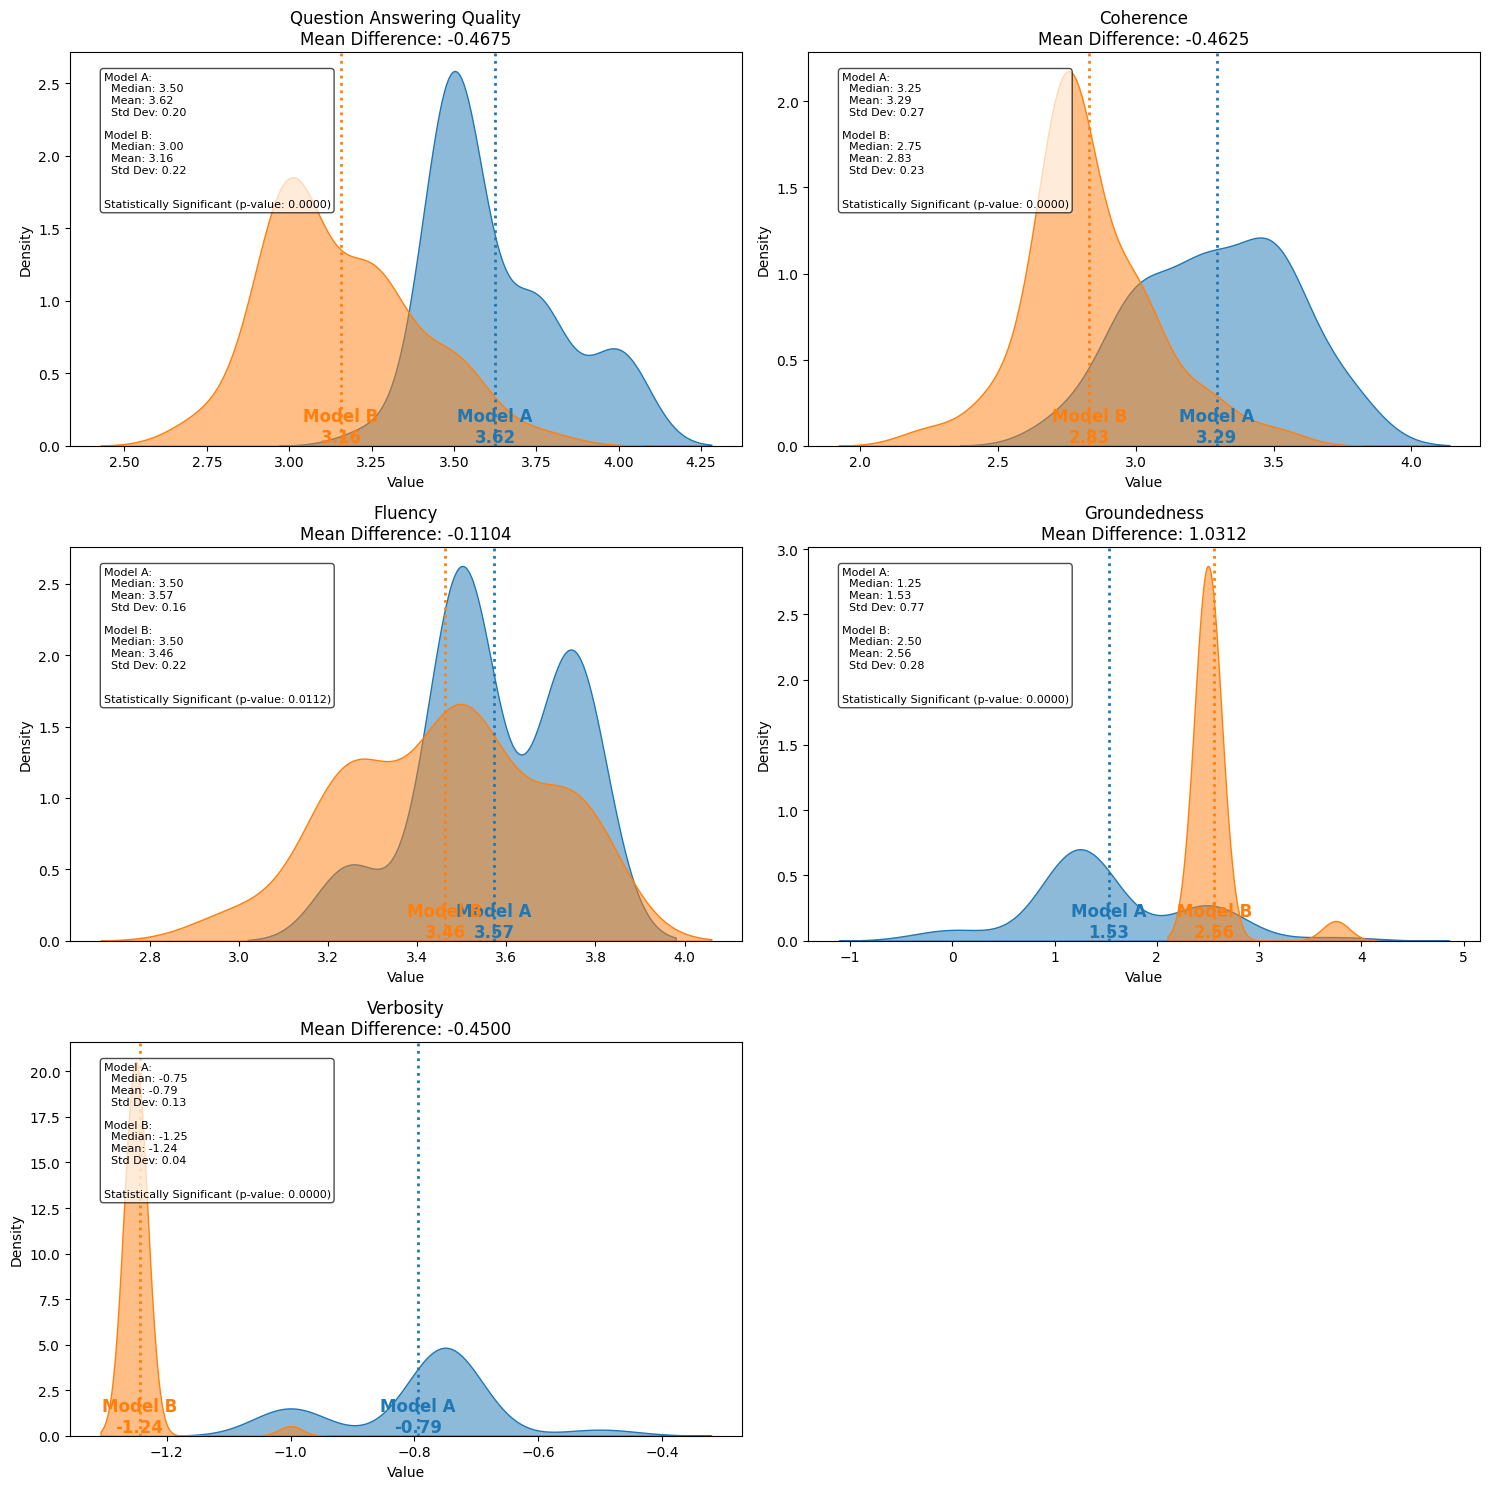

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sample data
dataframes = [model_a_results_df, model_b_results_df]
dataframe_names = ["Model A", "Model B"]


# Create KDE plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# Define a color palette
colors = ['#1f77b4', '#ff7f0e']  # You can add more colors if you have more dataframes

for i, metric in enumerate(mean_metrics):
    row, col = i // 2, i % 2

    means = []
    for df, name, color in zip(dataframes, dataframe_names, colors):
        # Plot KDE
        sns.kdeplot(data=df[metric], ax=axs[row, col], fill=True, alpha=0.5, label=name, color=color)

        # Calculate mean and plot dotted line
        mean_value = df[metric].mean()
        means.append(mean_value)
        axs[row, col].axvline(mean_value, color=color, linestyle=':', linewidth=2)

    # Calculate mean difference and perform t-test
    mean_diff = means[1] - means[0]
    t_stat, p_value = stats.ttest_ind(dataframes[0][metric], dataframes[1][metric])

    title = metric.split('/')[0].replace("_", " ").title()
    diff_title = f"{title}\nMean Difference: {mean_diff:.4f}"
    axs[row, col].set_title(diff_title, fontsize=12)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')


    # Add value labels at the bottom
    ylim = axs[row, col].get_ylim()
    for df, name, color, mean in zip(dataframes, dataframe_names, colors, means):
        axs[row, col].text(mean, ylim[0], f'{name}\n{mean:.2f}', color=color,
                           ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Add text annotations
    stats_text = ""
    for df, name in zip(dataframes, dataframe_names):
        median = df[metric].median()
        mean = df[metric].mean()
        std = df[metric].std()
        stats_text += f'{name}:\n  Median: {median:.2f}\n  Mean: {mean:.2f}\n  Std Dev: {std:.2f}\n\n'

    # Add statistical significance information
    if p_value < 0.02:
        sig_text = f"Statistically Significant (p-value: {p_value:.4f})"
    else:
        sig_text = f"Not Statistically Significant (p-value: {p_value:.4f})"

    stats_text += f"\n{sig_text}"

    axs[row, col].text(0.05, 0.95, stats_text,
                       transform=axs[row, col].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                       fontsize=8)

# Remove extra subplot
if len(metrics) % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

**Note:** We can evidence that sometimes the normal distribution is not as clear as other times, that is why is important to look at the charts before making any definitive conclusion

#**Comparing Results**

Now we can plot a more general overlapping view using a radar chart to understand in which areas the approaches differ

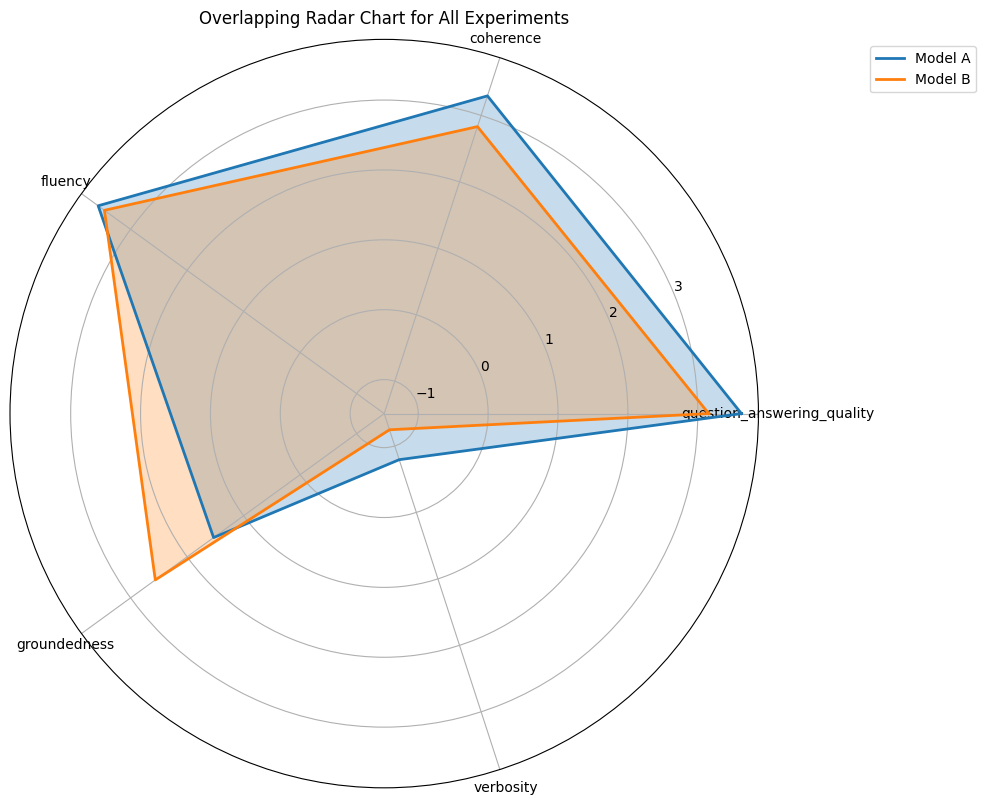

In [30]:
# Function to create radar chart
def radar_chart(data, title):
    angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
    values = data[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# # Create radar charts for each dataframe
# for df, name in zip(dataframes, dataframe_names):
#     radar_chart(df, f'Radar Chart for {name}')

# Create overlapping radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

for df, name in zip(dataframes, dataframe_names):
    values = df[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    ax.plot(angles, values, linewidth=2, label=name)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
ax.set_title('Overlapping Radar Chart for All Experiments')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we demonstrated the power of statistical analysis in understanding the performance of non-deterministic eval tasks. By leveraging techniques like the independent samples t-test, we moved beyond single-run observations to gain a more comprehensive understanding of the variability and underlying trends in our results.

The insights gleaned from this analysis can inform future iterations of the eval task, guide decision-making based on statistically sound evidence, and pave the way for more robust and reliable evaluations in the face of inherent uncertainty.

Note: The purpose of this analysis is not to have a rigorous statistical proof (since we are making a lot of assumptions), but to gain a more holistic view of the architecture's performance